In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# --- 1. DATA LOADING AND INITIAL INSPECTION ---

In [6]:
# Assuming the file is named 'Amazon Sale Report.csv' and is in the same directory.
# We use low_memory=False to handle potential mixed-type columns common in this dataset.
try:
    df = pd.read_excel('Amazon-Sales-Report-20K-Rows.xlsx')
except FileNotFoundError:
    print("ERROR: 'Amazon Sale Report.csv' not found. Please ensure the file is in the correct path.")
    # Create a small dummy DataFrame to allow the rest of the code to run without crashing
    data = {
        'Date': ['03-31-22', '03-31-22', '03-31-22'],
        'Category': ['Set', 'Western Dress', 'Top'],
        'Amount': [647.60, 1199.00, 399.00],
        'Fulfilment': ['Amazon', 'Merchant', 'Amazon'],
        'B2B': [False, True, False]
    }
    df = pd.DataFrame(data)
    print("Using a dummy DataFrame for demonstration.")


print("--- Initial Data Shape and Info ---")
print(f"Number of Rows: {df.shape[0]}, Number of Columns: {df.shape[1]}")
df.info()
print("\nFirst 5 Rows of Data:")
print(df.head())

--- Initial Data Shape and Info ---
Number of Rows: 20002, Number of Columns: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                20002 non-null  datetime64[ns]
 1   Status              20002 non-null  object        
 2   Fulfilment          20002 non-null  object        
 3   Sales Channel       20002 non-null  object        
 4   ship-service-level  20002 non-null  object        
 5   Category            20002 non-null  object        
 6   Size                20002 non-null  object        
 7   Courier Status      20002 non-null  object        
 8   Qty                 20002 non-null  int64         
 9   currency            20002 non-null  object        
 10  Amount              20002 non-null  float64       
 11  ship-city           20002 non-null  object        
 12  ship-state          2

# --- 2. DATA CLEANING AND PREPROCESSING ---

In [7]:
# A. Drop known irrelevant/unnecessary columns common in this dataset
columns_to_drop = ['index', 'Unnamed: 22', 'fulfilled-by', 'Sales Channel ']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

# B. Convert 'Date' to datetime objects for time series analysis
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')
df['Month'] = df['Date'].dt.to_period('M')

# C. Clean and fill missing values for key EDA columns

# Fill missing 'Amount' with 0 (as these are often cancelled/returned orders)
df['Amount'].fillna(0, inplace=True)

# D. Clean 'Category' column (remove any leading/trailing spaces)
df['Category'] = df['Category'].str.strip()

# E. Rename the 'B2B' column to be more descriptive of its values
df.rename(columns={'B2B': 'Customer Type'}, inplace=True)
df['Customer Type'] = df['Customer Type'].replace({True: 'Business', False: 'Individual'})


print("\n--- Data Cleaning Summary ---")
print(f"After dropping columns, new shape: {df.shape}")
print(f"Total Sales Amount (after cleaning nulls): ₹{df['Amount'].sum():,.2f}")


--- Data Cleaning Summary ---
After dropping columns, new shape: (20002, 17)
Total Sales Amount (after cleaning nulls): ₹11,672,354.01


# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---

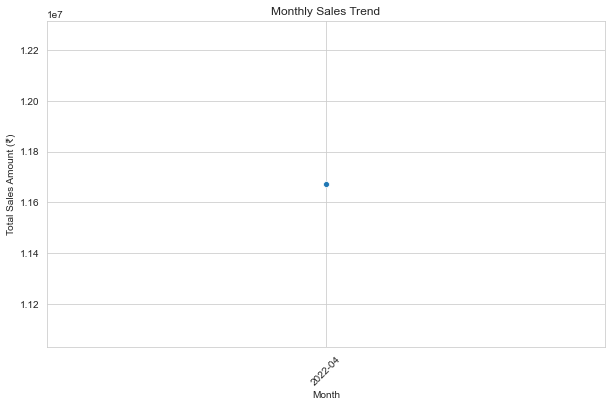

In [8]:
## 3.1 Univariate Analysis: Sales over Time

# Total Monthly Sales Trend
monthly_sales = df.groupby('Month')['Amount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str) # Convert Period to string for plotting

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Amount', data=monthly_sales, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount (₹)')
plt.xticks(rotation=45)
plt.show()

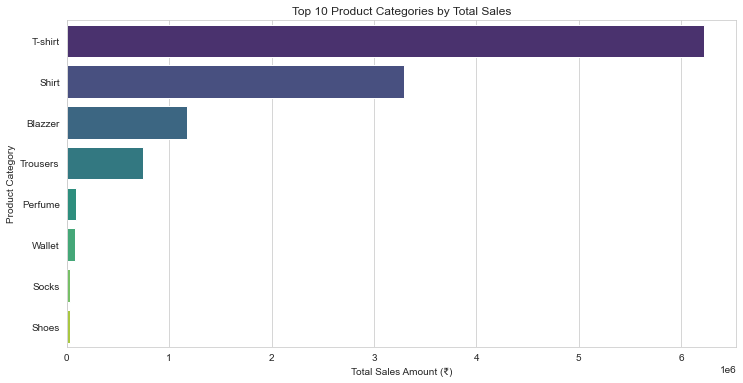

In [9]:
## 3.2 Univariate Analysis: Top Categories by Sales

# Group by Category and sum the Amount
category_sales = df.groupby('Category')['Amount'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Amount', y='Category', data=category_sales, palette='viridis')
plt.title('Top 10 Product Categories by Total Sales')
plt.xlabel('Total Sales Amount (₹)')
plt.ylabel('Product Category')
plt.show()

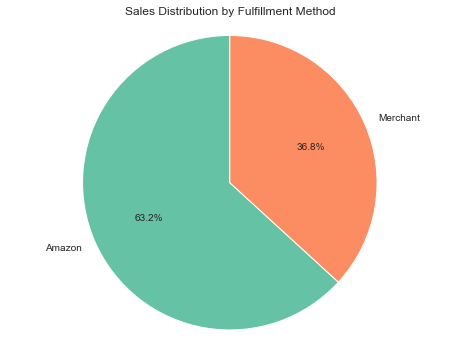

In [10]:
## 3.3 Bivariate Analysis: Sales by Fulfillment Type

fulfillment_sales = df.groupby('Fulfilment')['Amount'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.pie(fulfillment_sales['Amount'], labels=fulfillment_sales['Fulfilment'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Sales Distribution by Fulfillment Method')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

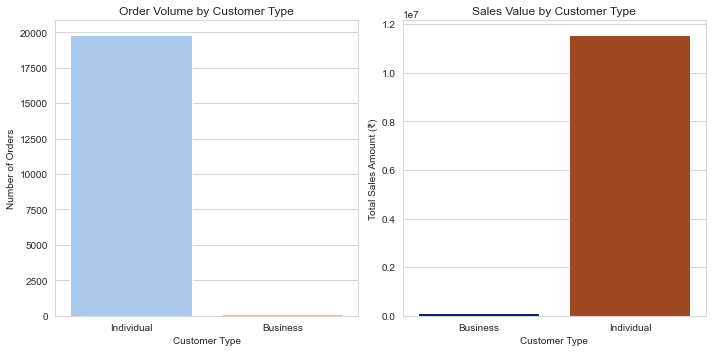

In [12]:
## 3.4 Bivariate Analysis: Customer Type (B2B vs Individual)

customer_type_counts = df['Customer Type'].value_counts().reset_index()
customer_type_counts.columns = ['Customer Type', 'Order Count']
customer_type_sales = df.groupby('Customer Type')['Amount'].sum().reset_index()
# Visualization 1: Order Count by Customer Type
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Customer Type', y='Order Count', data=customer_type_counts, palette='pastel')
plt.title('Order Volume by Customer Type')
plt.ylabel('Number of Orders')

# Visualization 2: Total Sales by Customer Type
plt.subplot(1, 2, 2)
sns.barplot(x='Customer Type', y='Amount', data=customer_type_sales, palette='dark')
plt.title('Sales Value by Customer Type')
plt.ylabel('Total Sales Amount (₹)')

plt.tight_layout()
plt.show()


--- Top 5 Categories Sales Split by Fulfillment ---
Fulfilment   Amazon    Merchant
Category                       
T-shirt     3990091  2236758.13
Shirt       2024227  1265001.81
Blazzer      667138   506020.47
Trousers     555314   186528.09
Perfume       45697    49854.90


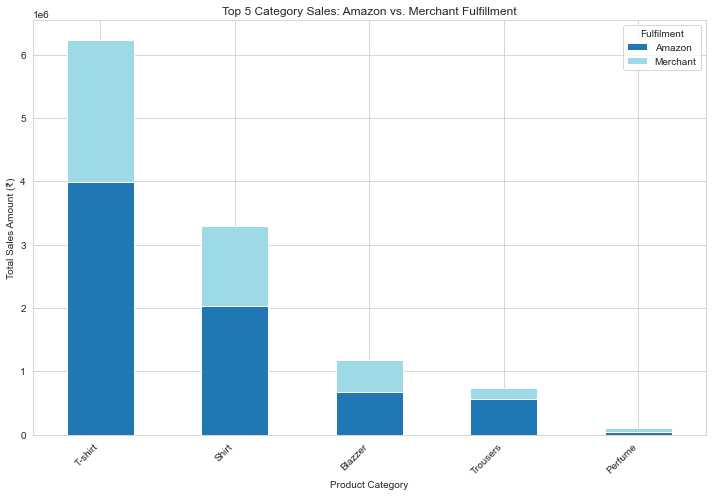

In [13]:
## 3.5 Multivariate Analysis: Category Sales by Fulfillment Method

# Pivot table for Category and Fulfilment
category_fulfillment_sales = df.pivot_table(
    values='Amount',
    index='Category',
    columns='Fulfilment',
    aggfunc='sum',
    fill_value=0
).sort_values(by='Amazon', ascending=False).head(5) # Top 5 categories for visualization

print("\n--- Top 5 Categories Sales Split by Fulfillment ---")
print(category_fulfillment_sales)

# Stacked Bar Plot
category_fulfillment_sales.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')
plt.title('Top 5 Category Sales: Amazon vs. Merchant Fulfillment')
plt.xlabel('Product Category')
plt.ylabel('Total Sales Amount (₹)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Fulfilment')
plt.tight_layout()
plt.show()

# --- 4. KEY FINDINGS SUMMARY ---

In [14]:
print("\n--- Key EDA Findings ---")
print(f"Total Analysis Period: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Revenue Generated: ₹{df['Amount'].sum():,.2f}")
print(f"Top Selling Category: {category_sales.iloc[0]['Category']} with ₹{category_sales.iloc[0]['Amount']:,.2f} in sales.")

amazon_fulfilment_percent = fulfillment_sales[fulfillment_sales['Fulfilment'] == 'Amazon']['Amount'].iloc[0] / df['Amount'].sum() * 100
print(f"Amazon Fulfillment accounts for {amazon_fulfilment_percent:.1f}% of total sales.")

business_sales_value = customer_type_sales[customer_type_sales['Customer Type'] == 'Business']['Amount'].iloc[0]
print(f"B2B (Business) customers contribute ₹{business_sales_value:,.2f} to the total sales.")


--- Key EDA Findings ---
Total Analysis Period: 2022-04-18 to 2022-04-30
Total Revenue Generated: ₹11,672,354.01
Top Selling Category: T-shirt with ₹6,226,849.13 in sales.
Amazon Fulfillment accounts for 63.2% of total sales.
B2B (Business) customers contribute ₹107,107.38 to the total sales.
